data berhasil diambil :}
  periode_data bulan tanggal          stasiun  pm_sepuluh  pm_duakomalima  \
0       202401    01      21  DKI3  Jagakarsa        51.0            65.0   
1       202401    01      22  DKI3  Jagakarsa        27.0            34.0   
2       202401    01      23  DKI3  Jagakarsa         NaN            52.0   
3       202401    01      24  DKI3  Jagakarsa        46.0            65.0   
4       202401    01      25  DKI3  Jagakarsa        37.0            55.0   

   sulfur_dioksida  karbon_monoksida  ozon  nitrogen_dioksida   max  \
0             45.0               9.0   8.0               79.0  79.0   
1             45.0               5.0   8.0               56.0  56.0   
2             46.0               6.0   9.0               51.0  52.0   
3             46.0               8.0   9.0               38.0  65.0   
4             47.0               7.0  11.0               28.0  55.0   

  parameter_pencemar_kritis kategori  
0                      null   SEDANG  
1      

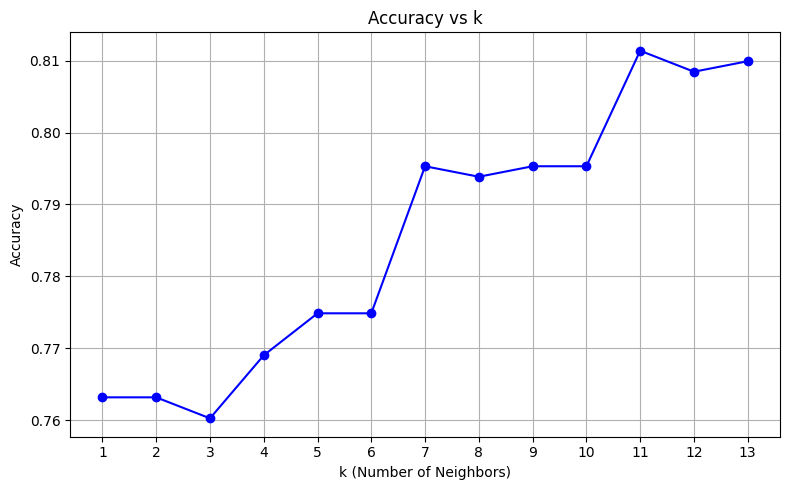


Confusion Matrix:
                SEDANG  BAIK  TIDAK SEHAT  TIDAK ADA DATA
SEDANG             426    17            0               0
BAIK                95   129            0               0
TIDAK SEHAT         11     0            0               0
TIDAK ADA DATA       6     0            0               0

Accuracy: 0.81


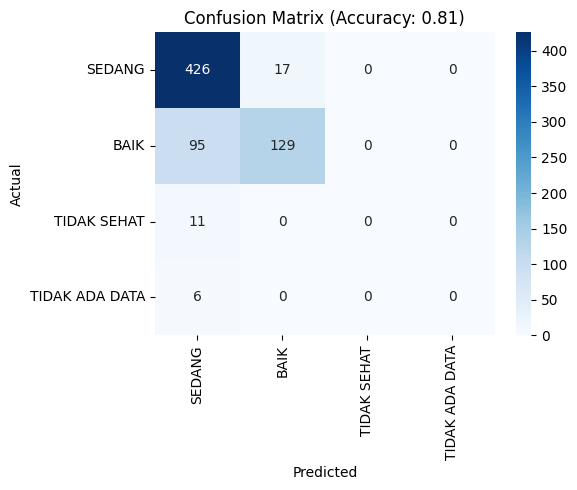

In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# URL dari Dataset https://satudata.jakarta.go.id/open-data/detail?kategori=dataset&page_url=data-indeks-standar-pencemar-udara-ispu-di-provinsi-dki-jakarta&data_no=1
url = "https://ws.jakarta.go.id/gateway/DataPortalSatuDataJakarta/1.0/satudata?kategori=dataset&tipe=detail&url=data-indeks-standar-pencemar-udara-ispu-di-provinsi-dki-jakarta"

response = requests.get(url)

if response.status_code == 200:
    json_data = response.json()
    records = json_data.get('data', [])
    df = pd.DataFrame(records)
    numeric_columns = ['pm_sepuluh', 'pm_duakomalima', 'sulfur_dioksida', 
                       'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    print("data berhasil diambil :}")
    print(df.head())
else:
    print(f"error: {response.status_code}")

# Fitur tambahan
df['pm_ratio'] = df['pm_duakomalima'] / df['pm_sepuluh']
df['gas_ratio'] = (df['sulfur_dioksida'] + df['nitrogen_dioksida']) / (df['karbon_monoksida'] + df['ozon'] + 1e-6)

# Gunakan fitur numerik
features = ['pm_sepuluh', 'pm_duakomalima', 'sulfur_dioksida', 'karbon_monoksida', 'ozon',
            'nitrogen_dioksida', 'max', 'pm_ratio', 'gas_ratio']

# Manual standardization
scalers = {}
for col in features:
    mean = df[col].mean()
    std = df[col].std()
    scalers[col] = (mean, std)
    df[col] = df[col].apply(lambda x: (x - mean) / std if std != 0 else 0)

# Manual label encoding
label_map = {}
reverse_map = {}
for i, label in enumerate(df['kategori'].unique()):
    label_map[label] = i
    reverse_map[i] = label

df['label'] = df['kategori'].map(label_map)

# Manual split: 70% train, 30% test
data_list = df.to_dict('records')
train_size = int(0.7 * len(data_list))
train_data = data_list[:train_size]
test_data = data_list[train_size:]

# KNN manual
def euclidean_distance(a, b):
    return math.sqrt(sum((a[feat] - b[feat]) ** 2 for feat in features))

def get_neighbors(train, test_sample, k):
    distances = []
    for sample in train:
        dist = euclidean_distance(sample, test_sample)
        distances.append((sample, dist))
    distances.sort(key=lambda x: x[1])
    return distances[:k]

def predict_classification(train, test_sample, k):
    neighbors = get_neighbors(train, test_sample, k)
    class_votes = {}
    for neighbor, dist in neighbors:
        label = neighbor['label']
        weight = 1 / (dist + 1e-6)  # inverse distance
        class_votes[label] = class_votes.get(label, 0) + weight
    return max(class_votes.items(), key=lambda x: x[1])[0]

# Cari akurasi dengan k terbaik dari 1 sampai 13
accuracies = []
k_values = list(range(1, 14))
best_k = 1
best_acc = 0

for k in k_values:
    correct = 0
    for sample in test_data:
        pred = predict_classification(train_data, sample, k)
        if pred == sample['label']:
            correct += 1
    acc = correct / len(test_data)
    accuracies.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"k Terbaik : {best_k} accuracy: {best_acc:.2f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title('Accuracy vs k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()


# Final prediction
y_true = []
y_pred = []
for sample in test_data:
    y_true.append(sample['label'])
    y_pred.append(predict_classification(train_data, sample, best_k))

# Evaluasi manual
labels = sorted(set(y_true + y_pred))
label_names = [reverse_map[l] for l in labels]

conf_matrix = pd.DataFrame(0, index=label_names, columns=label_names)
for true, pred in zip(y_true, y_pred):
    conf_matrix.loc[reverse_map[true], reverse_map[pred]] += 1

# Print hasil
print("\nConfusion Matrix:")
print(conf_matrix)

accuracy = sum([1 for i in range(len(y_true)) if y_true[i] == y_pred[i]]) / len(y_true)
print(f"\nAccuracy: {accuracy:.2f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

